# Negative L1 norm prior experiment

This code attempts to learn the 8D prior
$J(x) = -||x||_1$
assuming we have access to training data $\{y_i, S(y_i)\}$, $S(y_i) = -t/2 - |x|$

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/NegL1_prior_8D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,t=1.0):
    # Negative L1 Norm J(x) = -||x||_1
    # S(x, t) = -t/2 - |x| (per dimension)
    # For n dimensions: S(x, t) = - (n*t)/2 - ||x||_1
    
    dim = y.shape[1]
    l1_norm = np.sum(np.abs(y), axis=1)
    return -(dim*t) / 2.0 - l1_norm


def prior_true(y):
    # J(x) = -||x||_1
    return -np.sum(np.abs(y), axis=1)


def cvx_true(y,t=1.0):
    '''
    Computes Psi(y) = 0.5*||y||^2 - S(y,t).
    The target convex function to learn.
    '''
    return 0.5 * euclid_norm_sq(y) - hjsol_true(y, t)


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,t=1.0) 
    x2_0_cvx_true = cvx_true(x2_0_points,t=1.0)

    x1_0_prior_true = prior_true(x1_0_points)
    x2_0_prior_true = prior_true(x2_0_points)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_cvx_est, "-", label="LPN")
    plt.plot(xi, x1_0_cvx_true, "--", label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the convex function, Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Convex functions(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_cvx_est, "-", label="LPN")
        plt.plot(xi, x2_0_cvx_true, "--", label="Ref")
        plt.grid(True)
        plt.title(f"Cross sections ($0,x_2$,0) of the convex function, Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Convex functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_prior_est, "-",label="LPN")
    plt.plot(xi, x1_0_prior_true, "-",label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the prior function,Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('Prior functions ($x_1$,0)')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_prior_est, "-", label="LPN")
        plt.plot(xi, x2_0_prior_true, "-", label="Ref")
        plt.grid("on")
        plt.title(f"Cross sections ($0,x_2$,0) of the prior function,Dim {dim}")
        plt.xlabel('$x_1$')
        plt.ylabel('Prior functions ($0,x_2$,0)')
        plt.legend()
    plt.tight_layout()

def plot_all(model,a,spacing,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 8

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 30000
Iterations = 500000

# LPN model parameters
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,t=1.0).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-3
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 1561.52880859375
iteration 0 loss 35.86165237426758


iteration 5000 loss 0.04697231203317642


iteration 10000 loss 0.03931865841150284


iteration 15000 loss 0.03191613033413887


iteration 20000 loss 0.054388586431741714


iteration 25000 loss 0.023506615310907364


iteration 30000 loss 0.020730147138237953


iteration 35000 loss 0.01837410219013691


iteration 40000 loss 0.016304342076182365


iteration 45000 loss 0.0171992015093565


iteration 50000 loss 0.013133387081325054


iteration 55000 loss 0.01196329016238451


iteration 60000 loss 0.01093310583382845


iteration 65000 loss 0.01010623574256897


iteration 70000 loss 0.009330020286142826


iteration 75000 loss 0.008962277323007584


iteration 80000 loss 0.008165013045072556


iteration 85000 loss 0.06704507023096085


iteration 90000 loss 0.02259788103401661


iteration 95000 loss 0.006850691977888346


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.006495473440736532


iteration 105000 loss 0.006210402585566044


iteration 110000 loss 0.0057721748016774654


iteration 115000 loss 0.006246137898415327


iteration 120000 loss 0.005214987322688103


iteration 125000 loss 0.0049910577945411205


iteration 130000 loss 0.004800477530807257


iteration 135000 loss 0.004619221668690443


iteration 140000 loss 0.004456934053450823


iteration 145000 loss 0.004310867749154568


iteration 150000 loss 0.004177695140242577


iteration 155000 loss 0.004051293712109327


iteration 160000 loss 0.003935135435312986


iteration 165000 loss 0.003823805134743452


iteration 170000 loss 0.0037191451992839575


iteration 175000 loss 0.003618980757892132


iteration 180000 loss 0.003523765131831169


iteration 185000 loss 0.0034344291780143976


iteration 190000 loss 0.003351209918037057


iteration 195000 loss 0.0032705587800592184


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.0031944429501891136


iteration 205000 loss 0.0031616496853530407


iteration 210000 loss 0.0030973393004387617


iteration 215000 loss 0.003036453854292631


iteration 220000 loss 0.002978552132844925


iteration 225000 loss 0.0029236506670713425


iteration 230000 loss 0.002871178090572357


iteration 235000 loss 0.0028190435841679573


iteration 240000 loss 0.002773297019302845


iteration 245000 loss 0.0027278715278953314


iteration 250000 loss 0.002686192747205496


iteration 255000 loss 0.0026458636857569218


iteration 260000 loss 0.002606605878099799


iteration 265000 loss 0.0025692081544548273


iteration 270000 loss 0.0025332788936793804


iteration 275000 loss 0.002500804839655757


iteration 280000 loss 0.0024691694416105747


iteration 285000 loss 0.002438163384795189


iteration 290000 loss 0.002407846273854375


iteration 295000 loss 0.0023788437247276306


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.0023516658693552017


iteration 305000 loss 0.002340270671993494


iteration 310000 loss 0.0023131289053708315


iteration 315000 loss 0.002286814386025071


iteration 320000 loss 0.0022617403883486986


iteration 325000 loss 0.00223768618889153


iteration 330000 loss 0.0022136096376925707


iteration 335000 loss 0.0021902539301663637


iteration 340000 loss 0.0021673121955245733


iteration 345000 loss 0.0021448503248393536


iteration 350000 loss 0.0021228769328445196


iteration 355000 loss 0.002101637190207839


iteration 360000 loss 0.002082358580082655


iteration 365000 loss 0.0020621861331164837


iteration 370000 loss 0.002042593667283654


iteration 375000 loss 0.002023235894739628


iteration 380000 loss 0.0020043798722326756


iteration 385000 loss 0.0019863040652126074


iteration 390000 loss 0.0019687756430357695


iteration 395000 loss 0.0019507060060277581


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 0.0019331538351252675


iteration 405000 loss 0.0019284586887806654


iteration 410000 loss 0.0019194470951333642


iteration 415000 loss 0.0019105518003925681


iteration 420000 loss 0.0019018143648281693


iteration 425000 loss 0.001893230713903904


iteration 430000 loss 0.0018847942119464278


iteration 435000 loss 0.0018764609703794122


iteration 440000 loss 0.001868235762231052


iteration 445000 loss 0.0018601111369207501


iteration 450000 loss 0.0018520911689847708


iteration 455000 loss 0.0018441594438627362


iteration 460000 loss 0.0018363092094659805


iteration 465000 loss 0.0018285433761775494


iteration 470000 loss 0.0018208533292636275


iteration 475000 loss 0.0018132394179701805


iteration 480000 loss 0.0018056972185149789


iteration 485000 loss 0.001798227895051241


iteration 490000 loss 0.0017908259760588408


iteration 495000 loss 0.0017835122998803854


L2 loss -- Plot

loss 208.7030029296875


loss 143.4917449951172


loss 111.8409194946289


loss 92.59788513183594


loss 80.36740112304688


loss 72.85258483886719


loss 68.63308715820312


loss 66.55535888671875


loss 65.6882553100586


loss 65.39196014404297


loss 65.31230926513672


loss 65.29635620117188


loss 65.29414367675781


loss 65.29396057128906


loss 65.29395294189453


loss 65.2939453125


loss 65.2939453125


loss 65.2939453125


loss 65.29395294189453


loss 65.29395294189453


loss 65.2939453125


loss 65.2939453125


loss 65.29395294189453


loss 65.29396057128906


loss 65.29395294189453


loss 65.2939453125


loss 65.2939453125


loss 65.2939453125


loss 65.2939453125


loss 65.2939453125


loss 65.2939453125


loss 65.2939453125


loss 65.2939453125


loss 65.2939453125


loss 65.2939453125


loss 65.2939453125


loss 65.2939453125


loss 65.29395294189453


loss 65.2939453125


loss 65.2939453125


final mse:  8.281584307212597e-09
max, min: 2.9963698 -2.9293752
loss 208.7030029296875


loss 144.4284210205078


loss 113.08456420898438


loss 93.65191650390625


loss 81.15863800048828


loss 73.39826202392578


loss 68.96688842773438


loss 66.74270629882812


loss 65.8003921508789


loss 65.47662353515625


loss 65.3907470703125


loss 65.37434387207031


loss 65.37228393554688


loss 65.37213134765625


loss 65.37213134765625


loss 65.37213134765625


loss 65.37212371826172


loss 65.37212371826172


loss 65.37213897705078


loss 65.37213134765625


loss 65.37213134765625


loss 65.37213134765625


loss 65.37213897705078


loss 65.37213134765625


loss 65.37213134765625


loss 65.37213134765625


loss 65.37213134765625


loss 65.37213134765625


loss 65.37213134765625


loss 65.37212371826172


loss 65.37213134765625


loss 65.37213134765625


loss 65.37213134765625


loss 65.37213134765625


loss 65.37212371826172


loss 65.37213134765625


loss 65.37213134765625


loss 65.37213134765625


loss 65.37212371826172


loss 65.37212371826172


final mse:  8.333086221057329e-09
max, min: 3.0139947 -2.9720738


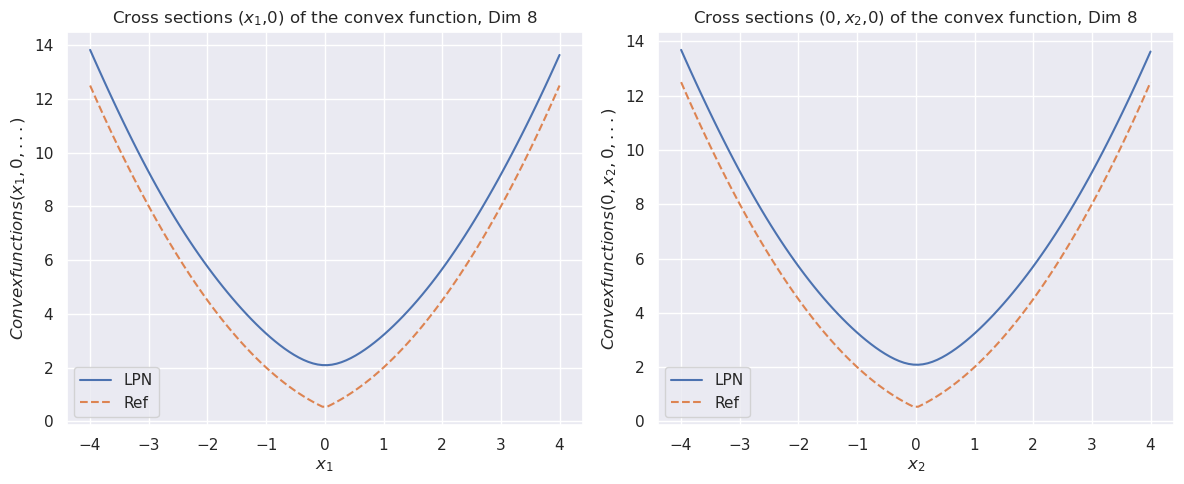

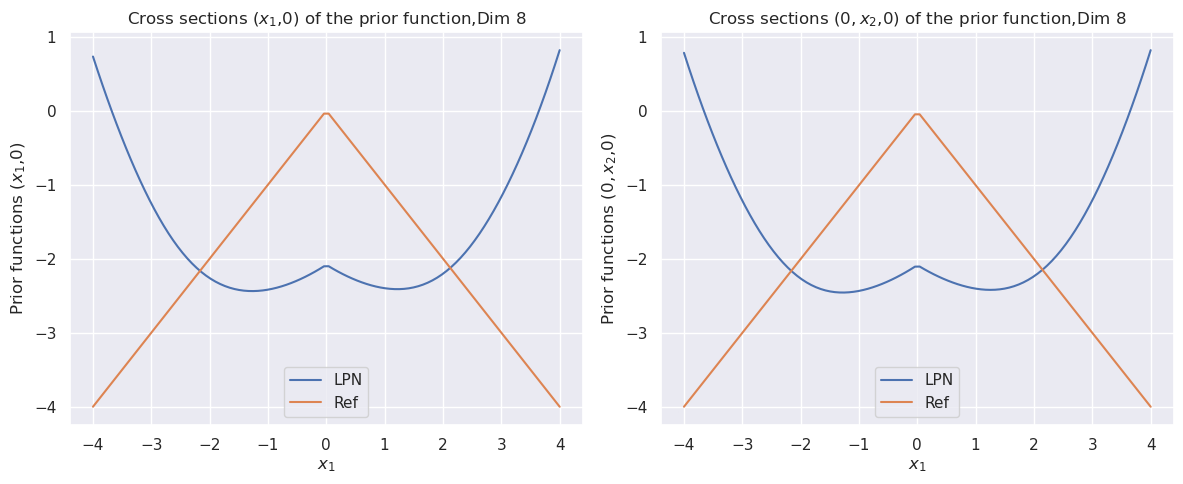

In [7]:
plot_all(lpn_model,a,spacing,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

G_samples_tensor = G_samples_tensor_with_graph.detach().to(device)

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)

# --- Train 2nd LPN ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-3 
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of 2nd LPN complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 480.36199951171875
iteration 0 loss 1073.069580078125


iteration 5000 loss 0.29261791706085205


iteration 10000 loss 0.18496191501617432


iteration 15000 loss 0.1220465824007988


iteration 20000 loss 0.08960416913032532


iteration 25000 loss 0.05566329136490822


iteration 30000 loss 0.037981223315000534


iteration 35000 loss 0.024014150723814964


iteration 40000 loss 0.015426925383508205


iteration 45000 loss 0.01020982675254345


iteration 50000 loss 0.03878498077392578


iteration 55000 loss 0.0067896293476223946


iteration 60000 loss 0.48256146907806396


iteration 65000 loss 0.005070087965577841


iteration 70000 loss 0.004271286074072123


iteration 75000 loss 0.004273808095604181


iteration 80000 loss 0.0036103064194321632


iteration 85000 loss 0.003107207827270031


iteration 90000 loss 0.0029961601831018925


iteration 95000 loss 0.0025564413517713547


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.0024241656064987183


iteration 105000 loss 0.002106850268319249


iteration 110000 loss 0.0018303128890693188


iteration 115000 loss 0.001625118195079267


iteration 120000 loss 0.0014651590026915073


iteration 125000 loss 0.0013280875282362103


iteration 130000 loss 0.001214230083860457


iteration 135000 loss 0.001117992796935141


iteration 140000 loss 0.001037506852298975


iteration 145000 loss 0.0009683629032224417


iteration 150000 loss 0.000909311871509999


iteration 155000 loss 0.0008584161405451596


iteration 160000 loss 0.0008141820435412228


iteration 165000 loss 0.0007762423483654857


iteration 170000 loss 0.0007429641555063426


iteration 175000 loss 0.0007140100351534784


iteration 180000 loss 0.0006884735776111484


iteration 185000 loss 0.0006652764859609306


iteration 190000 loss 0.0006447857595048845


iteration 195000 loss 0.0006266394630074501


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.0006098672747612


iteration 205000 loss 0.0006019849679432809


iteration 210000 loss 0.0005884143756702542


iteration 215000 loss 0.0005744746304117143


iteration 220000 loss 0.0008789621060714126


iteration 225000 loss 0.0005507598398253322


iteration 230000 loss 0.0005406432901509106


iteration 235000 loss 0.0005308691179379821


iteration 240000 loss 0.0005211453535594046


iteration 245000 loss 0.0005133855738677084


iteration 250000 loss 0.0005054624634794891


iteration 255000 loss 0.0004980466910637915


iteration 260000 loss 0.0004912307485938072


iteration 265000 loss 0.00048457965021952987


iteration 270000 loss 0.00047842386993579566


iteration 275000 loss 0.00047250144416466355


iteration 280000 loss 0.000466742116259411


iteration 285000 loss 0.0004616478399839252


iteration 290000 loss 0.00045654524001292884


iteration 295000 loss 0.0004513718595262617


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.00044660113053396344


iteration 305000 loss 0.0004448105755727738


iteration 310000 loss 0.00043955669389106333


iteration 315000 loss 0.0004350195813458413


iteration 320000 loss 0.00042984180618077517


iteration 325000 loss 0.00042503178701736033


iteration 330000 loss 0.00042133365059271455


iteration 335000 loss 0.000417121103964746


iteration 340000 loss 0.0004131911264266819


iteration 345000 loss 0.0004093007883056998


iteration 350000 loss 0.0004057808837387711


iteration 355000 loss 0.0004024964291602373


iteration 360000 loss 0.00039899456896819174


iteration 365000 loss 0.0003956767322961241


iteration 370000 loss 0.00039229000685736537


iteration 375000 loss 0.00038959403173066676


iteration 380000 loss 0.0003867192135658115


iteration 385000 loss 0.00038368781679309905


iteration 390000 loss 0.00038098354707472026


iteration 395000 loss 0.0003784284635912627


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 0.0003757104277610779


iteration 405000 loss 0.00037512814742513


iteration 410000 loss 0.0003731391334440559


iteration 415000 loss 0.0003710745077114552


iteration 420000 loss 0.00036909879418089986


iteration 425000 loss 0.00036719191120937467


iteration 430000 loss 0.0003653386374935508


iteration 435000 loss 0.0003635339089669287


iteration 440000 loss 0.0003617717302404344


iteration 445000 loss 0.0003600477648433298


iteration 450000 loss 0.0003583620418794453


iteration 455000 loss 0.00035671208752319217


iteration 460000 loss 0.0003551007539499551


iteration 465000 loss 0.0003535198629833758


iteration 470000 loss 0.0003519736637827009


iteration 475000 loss 0.0003504571213852614


iteration 480000 loss 0.0003489687223918736


iteration 485000 loss 0.0003475079720374197


iteration 490000 loss 0.00034607446286827326


iteration 495000 loss 0.0003446651971898973


Training of 2nd LPN complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


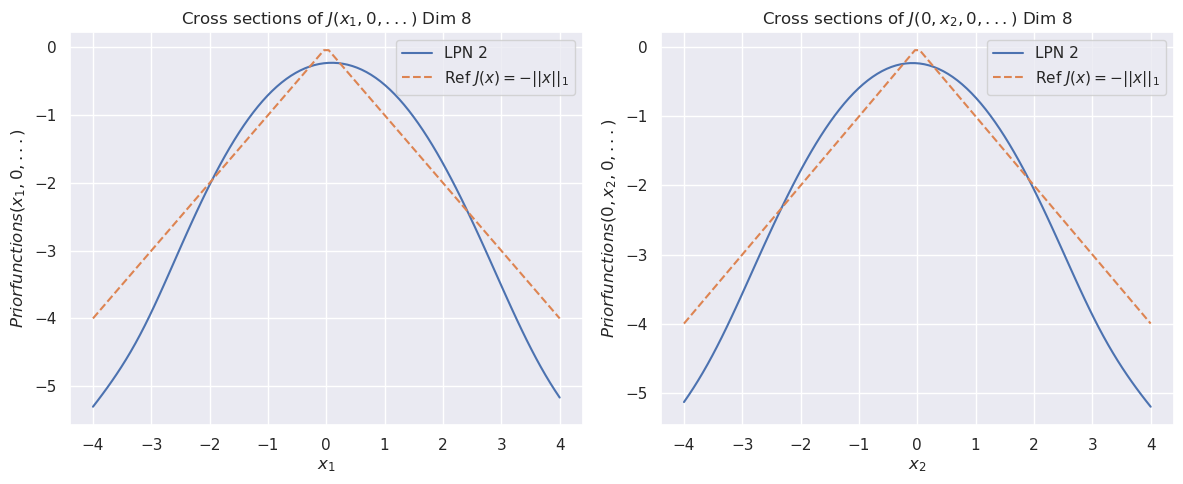

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=-||x||_1$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Prior functions (x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=-||x||_1$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Prior functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim)